In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
from jax import numpy as np
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

In [3]:
import pennylane as qml
import pickle

with open('qubits_acai_8.pkl', 'rb') as file:
    qubits = pickle.load(file)
    
with open('H_acai_8.pkl', 'rb') as fp:
    H = pickle.load(fp) 
print("Number of qubits = ", qubits)

Number of qubits =  16


Implementing the VQE algorithm
==============================

From here on, we can use PennyLane as usual, employing its entire stack
of algorithms and optimizers. We begin by defining the device, in this
case PennyLane's standard qubit simulator:


In [4]:
dev = qml.device("lightning.qubit", wires=qubits)

In [5]:
electrons = int(qubits/2)
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


The `hf` array is used by the `~.pennylane.BasisState`{.interpreted-text
role="class"} operation to initialize the qubit register. Then, we just
act with the `~.pennylane.DoubleExcitation`{.interpreted-text
role="class"} operation on the four qubits. The next step is to compute
the expectation value of the molecular Hamiltonian in the trial state
prepared by the circuit. We do this using the
`~.expval`{.interpreted-text role="func"} function. The decorator syntax
allows us to run the cost function as an executable QNode with the gate
parameter $\theta$:


In [6]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    # Apply Hadamard to HOMO and LUMO
    for i in range(electrons*2):
        qml.Hadamard(wires=i)
        
    for i in range(electrons*2 -1):
        #Apply RY to even qubits
        if(i%2 == 0):
            qml.RY(param, wires=i)
        #Apply RX to odd qubits
        else:
            qml.RX(param, wires=i)
        #Apply CNOT 
        qml.CNOT(wires=[i,i+1])
    #Apply RX to the last qubits at LUMO
    qml.RX(param, wires = electrons*2 -1)
    
    return qml.expval(H)

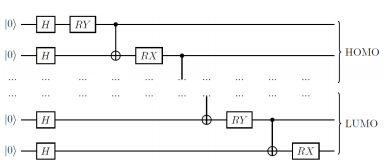

We can now define our error function simply as the expected value
calculated above:


In [7]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

Now we proceed to minimize the cost function to find the ground state of
the $\mathrm{H}_2$ molecule. To start, we need to define the classical
optimizer. The library `optax` offers different
[optimizers](https://optax.readthedocs.io/en/latest/api.html). Here we
use a basic gradient-descent optimizer. We carry out the optimization
over a maximum of 100 steps aiming to reach a convergence tolerance of
$10^{-6}$ for the value of the cost function.


In [8]:
import optax

max_iterations = 150
conv_tol = 1e-8

opt = optax.sgd(learning_rate=0.5)

We initialize the circuit parameter $\theta$ to zero, meaning that we
start from the Hartree-Fock state.


In [9]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)
    
    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/usr/local/lib/python3.9/site-packages/pennylane/math/utils.py:225: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step = 0,  Energy = -546.13623787 Ha
Step = 2,  Energy = -546.14777436 Ha
Step = 4,  Energy = -546.16007516 Ha
Step = 6,  Energy = -546.17279912 Ha
Step = 8,  Energy = -546.18551086 Ha
Step = 10,  Energy = -546.19773712 Ha
Step = 12,  Energy = -546.20904180 Ha
Step = 14,  Energy = -546.21909531 Ha
Step = 16,  Energy = -546.22771485 Ha
Step = 18,  Energy = -546.23486594 Ha
Step = 20,  Energy = -546.24063298 Ha
Step = 22,  Energy = -546.24517548 Ha
Step = 24,  Energy = -546.24868601 Ha
Step = 26,  Energy = -546.25135863 Ha
Step = 28,  Energy = -546.25336990 Ha
Step = 30,  Energy = -546.25487019 Ha
Step = 32,  Energy = -546.25598192 Ha
Step = 34,  Energy = -546.25680167 Ha
Step = 36,  Energy = -546.25740390 Ha
Step = 38,  Energy = -546.25784514 Ha
Step = 40,  Energy = -546.25816779 Ha
Step = 42,  Energy = -546.25840338 Ha
Step = 44,  Energy = -546.25857521 Ha
Step = 46,  Energy = -546.25870045 Ha
Step = 48,  Energy = -546.25879167 Ha
Step = 50,  Energy = -546.25885809 Ha
Step = 52,  Energ

Let\'s plot the values of the ground state energy of the molecule and
the gate parameter $\theta$ as a function of the optimization step.


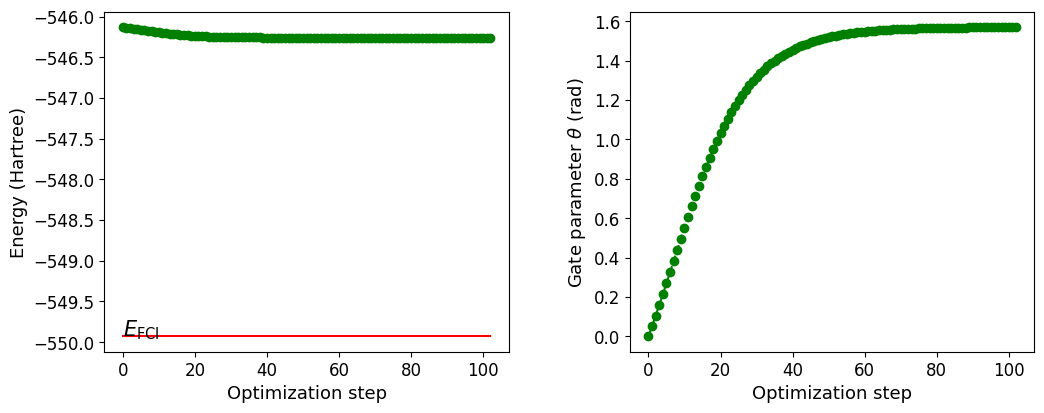

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -549.9281445557749

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
#ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -549.9281445557749, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In this case, the VQE algorithm converges after thirteen iterations. The
optimal value of the circuit parameter $\theta^* = 0.208$ defines the
state

$$\vert \Psi(\theta^*) \rangle = 0.994~\vert 1100 \rangle - 0.104~\vert 0011 \rangle,$$

which is precisely the ground state of the $\mathrm{H}_2$ molecule in a
minimal basis set approximation.

Conclusion
==========

In this tutorial, we have implemented the VQE algorithm to find the
ground state of the hydrogen molecule. We used a simple circuit to
prepare quantum states of the molecule beyond the Hartree-Fock
approximation. The ground-state energy was obtained by minimizing a cost
function defined as the expectation value of the molecular Hamiltonian
in the trial state.

The VQE algorithm can be used to simulate other chemical phenomena. In
the tutorial `tutorial_vqe_bond_dissociation`{.interpreted-text
role="doc"}, we use VQE to explore the potential energy surface of
molecules to simulate chemical reactions. Another interesting
application is to probe the lowest-lying states of molecules in specific
sectors of the Hilbert space. For example, see the tutorial
`tutorial_vqe_spin_sectors`{.interpreted-text role="doc"}. Furthermore,
the algorithm presented here can be generalized to find the equilibrium
geometry of a molecule as it is demonstrated in the tutorial
`tutorial_mol_geo_opt`{.interpreted-text role="doc"}.

References {#vqe_references}
==========

About the author
================
